In [1]:
import xarray as xr
import numpy as np

import os
import torch
import math
import tqdm
import random

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
temperature_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalTemperature/Land_and_Ocean_LatLong1.nc"
co2_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalGhgEmissions/CO2_1deg_month_1850-2013.nc"
ssp_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalGhgEmissions/CO2_SSP119_2015_2150.nc"

In [3]:
temperature_ds = xr.open_dataset(temperature_path)
co2_ds = xr.open_dataset(co2_path)

temperature_ds['time'] = temperature_ds['time'].assign_coords(time=np.arange(len(temperature_ds.time)))
co2_ds['Times'] = co2_ds['Times'].assign_coords(Times=np.arange(len(co2_ds.Times)))


ssp_ds = xr.open_dataset(ssp_path)
ssp_ds['time'] = ssp_ds['time'].assign_coords(time=np.arange(len(ssp_ds.time)))

In [4]:
# Extract temperature data
temperature_data = temperature_ds['temperature']
temperature_mean = temperature_data.mean()
temperature_std = temperature_data.std()
normalized_temperature = (temperature_data - temperature_mean) / temperature_std

climatology = temperature_ds['climatology']
land_mask = temperature_ds['land_mask']

data_dict = {
    'temperature': normalized_temperature,
    'climatology': climatology,
    'land_mask': land_mask,
    'co2': co2_ds['value'],
    'time_length': 1968, # 1850-2013
}

test_data_dict = {
    'temperature': normalized_temperature[1980:1980+109],
    'climatology': climatology,
    'land_mask': land_mask,
    'co2': ssp_ds['CO2'],
    'time_length': 108,  # 2015-2023
}


In [5]:
class TrainData(Dataset):
    def __init__(self, data_dict, seq_length):
        """
        Initializes the dataset with a dictionary of data variables.
        :param data_dict: Dictionary of data variables (e.g., {'temperature': ..., 'land_mask': ...}).
        :param seq_length: Number of historical steps used as input to the model.
        """
        self.data_dict = data_dict
        self.seq_length = seq_length
        # Assumes all data variables share the same latitude and longitude coordinates
        self.latitudes = data_dict['land_mask']['latitude'].values
        self.longitudes = data_dict['land_mask']['longitude'].values
        
        self.time_steps = data_dict['time_length'] - seq_length + 1

    def __len__(self):
        return 9000  # Randomly chosen number

    def __getitem__(self, index):
        while True:
            # Randomly select a location
            lat = random.choice(self.latitudes)
            lon = random.choice(self.longitudes)
            start_time = random.randint(0, self.time_steps - 1)  # Randomly select a starting time step

            temperature_sequence = self.data_dict['temperature'].sel(latitude=lat, longitude=lon, method="nearest").values
            co2_sequence = self.data_dict['co2'].sel(LatDim=int(89.5 - lat), LonDim=int(179.5 - lon)).values
            
            land_mask = self.data_dict['land_mask'].sel(latitude=lat, longitude=lon, method="nearest").values.item()  # Get scalar value
            lat_norm = lat / 90

            months = [(start_time + i) % 12 for i in range(self.seq_length + 1)]  # Calculate month for each timestep
            cos_months = [np.cos(2 * np.pi * month / 12) for month in months]
            sin_months = [np.sin(2 * np.pi * month / 12) for month in months]

            x_temp = temperature_sequence[start_time:start_time + self.seq_length]
            x_co2 = co2_sequence[start_time:start_time + self.seq_length]
            x_combined = list(zip(x_temp, x_co2))
            
            y = temperature_sequence[start_time + self.seq_length]

            if not np.isnan(x_temp).any() and not np.isnan(y):
                # Prepare input features for each timestep
                x_features = [np.append(np.array([temp[0], temp[1]]), [land_mask, lat_norm, cos_months[i], sin_months[i]]) for i, temp in enumerate(x_combined)]
                x_concat = np.stack(x_features)  # Stack to form a 2D array where each row is a timestep
                
                return torch.tensor(x_concat, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [6]:
class TestData(Dataset):
    def __init__(self, data_dict, seq_length):
        """
        Initializes the dataset with a dictionary of data variables.
        :param data_dict: Dictionary of data variables (e.g., {'temperature': ..., 'land_mask': ...}).
        :param seq_length: Number of historical steps used as input to the model.
        """
        self.data_dict = data_dict
        self.seq_length = seq_length
        # Assumes all data variables share the same latitude and longitude coordinates
        self.latitudes = data_dict['land_mask']['latitude'].values
        self.longitudes = data_dict['land_mask']['longitude'].values
        
        self.time_steps = data_dict['time_length'] - seq_length + 1

    def __len__(self):
        return 1000  # Randomly chosen number

    def __getitem__(self, index):
        while True:
            # Randomly select a location
            lat = random.choice(self.latitudes)
            lon = random.choice(self.longitudes)
            start_time = random.randint(0, self.time_steps - 1)  # Randomly select a starting time step

            temperature_sequence = self.data_dict['temperature'].sel(latitude=lat, longitude=lon, method="nearest").values
            co2_sequence = self.data_dict['co2'].sel(latitude=lat, longitude=lon, method="nearest").values
            
            land_mask = self.data_dict['land_mask'].sel(latitude=lat, longitude=lon, method="nearest").values.item()  # Get scalar value
            lat_norm = lat / 90

            months = [(start_time + i) % 12 for i in range(self.seq_length + 1)]  # Calculate month for each timestep
            cos_months = [np.cos(2 * np.pi * month / 12) for month in months]
            sin_months = [np.sin(2 * np.pi * month / 12) for month in months]

            x_temp = temperature_sequence[start_time:start_time + self.seq_length]
            x_co2 = co2_sequence[start_time:start_time + self.seq_length]
            x_combined = list(zip(x_temp, x_co2))
            
            y = temperature_sequence[start_time + self.seq_length]

            if not np.isnan(x_temp).any() and not np.isnan(y):
                # Prepare input features for each timestep
                x_features = [np.append(np.array([temp[0], temp[1]]), [land_mask, lat_norm, cos_months[i], sin_months[i]]) for i, temp in enumerate(x_combined)]
                x_concat = np.stack(x_features)  # Stack to form a 2D array where each row is a timestep
                
                return torch.tensor(x_concat, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [7]:
# Data parameters
seq_length = 24
batch_size = 16

# Create the Dataset
train_dataset = TrainData(data_dict, seq_length)
test_dataset = TestData(test_data_dict, seq_length)

# Split data into training and testing
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# print(train_size, val_size, len(test_dataset))
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Example: Iterate over train_loader
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break  # remove this break to process all batches

# for inputs, labels in val_loader:
#     print(inputs.shape, labels.shape)
#     break  # remove this break to process all batches

for inputs, labels in test_loader:
    print(inputs.shape, labels.shape)
    break  # remove this break to process all batches

torch.Size([16, 24, 6]) torch.Size([16])
torch.Size([16, 24, 6]) torch.Size([16])


In [8]:
# Device configuration - uses GPU if available
# Check for device availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"Using device: {device}")


Using device: mps


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Forward pass through RNN layer
        out, _ = self.rnn(x, h0)
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [11]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Forward pass through GRU layer
        out, _ = self.gru(x, h0)
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [12]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        
        # Forward pass through the first fully connected layer
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        
        # Forward pass through the second fully connected layer
        x = self.fc4(x)
        return x

In [13]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(AttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Compute attention weights
        energy = torch.tanh(self.attn(out))
        attention = torch.softmax(torch.matmul(energy, self.v), dim=1)
        
        attention = attention.unsqueeze(-1)
        
        # Apply attention weights to LSTM outputs
        context = attention * out
        context = torch.sum(context, dim=1)
        
        # Pass the context to the fully connected layer
        out = self.fc(context)
        return out

In [14]:
# Initialize the LSTM model
input_dim = 6  # input feature dimension
hidden_dim = 100  # number of features in hidden state
num_layers = 4  # number of stacked LSTM layers
output_dim = 1  # output feature dimension (predicting one value)

lstm = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
rnn = RNNModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
gru = GRUModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
mlp = MLPModel(input_dim * seq_length, hidden_dim, output_dim).to(device)
attn = AttentionModel(input_dim, hidden_dim, num_layers, output_dim).to(device)

# Parameters
num_epochs = 2

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs, criterion=nn.MSELoss(), optimizer=optim.Adam, learning_rate=0.001):
    # Train the model
    total_step = len(train_loader)
    
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    criterion = criterion
    model.to(device)
    
    min_loss = float('inf')
    best_model_path = "best_model.pth"
        
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {test_loss}')
        
        if test_loss < min_loss:
            min_loss = test_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved improved model with Test Loss: {test_loss}")

In [16]:
def evaluate_model(model, test_loader, criterion=nn.MSELoss()):
    total_val_loss = 0
    count = 0
    actual = []
    predicted = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = model(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1
            
            actual.extend(yb.tolist())
            predicted.extend(val_outputs.squeeze().tolist())

    avg_val_loss = total_val_loss / count
    print(f'Test Loss {avg_val_loss}')
    print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

    # Limit the data points to the first 100 for visualization
    actual = actual[200:260]
    predicted = predicted[200:260]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual Data', color='blue')
    plt.plot(predicted, label='Predicted Data', color='red')
    plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature (Normalized)')
    plt.legend()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume lstm initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()
lstm.to(device)  # Ensure the lstm is on the correct device

min_loss = float('inf')
best_model_path = 'best_model.pth'


for epoch in range(num_epochs):
    lstm.train()  # Make sure the lstm is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = lstm(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    lstm.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = lstm(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the lstm is back to train mode after validation
lstm.train()


/opt/homebrew/Caskroom/miniforge/base/envs/climate/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniforge/base/envs/climate/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/2, Train Loss: 0.9640458569751116, Val Loss: 2.312597752563537
Saved improved model with Test Loss: 2.312597752563537
Epoch 2/2, Train Loss: 0.9396681067786886, Val Loss: 1.6786083720979237
Saved improved model with Test Loss: 1.6786083720979237
Test Loss 1.864837279631978
Actual mean: 0.7512978469183436, Predicted mean: -0.009177404165267944


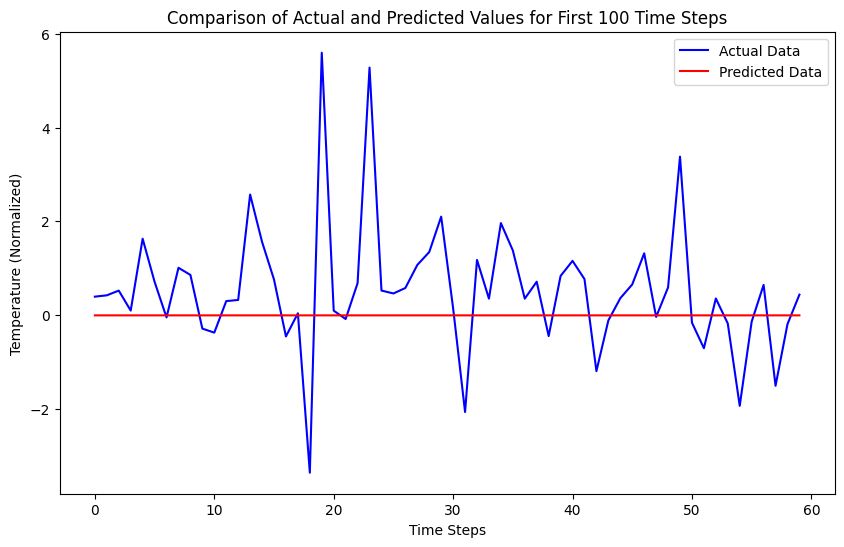

In [17]:
train_model(lstm, train_loader, test_loader, num_epochs, criterion=nn.MSELoss(), optimizer=optim.Adam, learning_rate=0.001)
evaluate_model(lstm, test_loader, criterion=nn.MSELoss())

In [ ]:
lstm.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = lstm(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume rnn initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()
rnn.to(device)  # Ensure the rnn is on the correct device

for epoch in range(num_epochs):
    rnn.train()  # Make sure the rnn is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = rnn(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    rnn.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = rnn(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')
    

# Optionally, you may want to ensure the rnn is back to train mode after validation
rnn.train()


In [ ]:
rnn.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = rnn(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume gru initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(gru.parameters(), lr=0.001)
criterion = nn.MSELoss()
gru.to(device)  # Ensure the gru is on the correct device

for epoch in range(num_epochs):
    gru.train()  # Make sure the gru is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = gru(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    gru.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = gru(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')
    

# Optionally, you may want to ensure the gru is back to train mode after validation
gru.train()


In [ ]:
gru.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = gru(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume mlp initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()
mlp.to(device)  # Ensure the mlp is on the correct device

for epoch in range(num_epochs):
    mlp.train()  # Make sure the mlp is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = mlp(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    mlp.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = mlp(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the mlp is back to train mode after validation
mlp.train()


Epoch 0: Train Loss 0.4679151773452759, Val Loss 1.7397346217480918


KeyboardInterrupt: 

In [ ]:
mlp.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = mlp(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume attn initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(attn.parameters(), lr=0.001)
criterion = nn.MSELoss()
attn.to(device)  # Ensure the attn is on the correct device

for epoch in range(num_epochs):
    attn.train()  # Make sure the attn is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = attn(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    attn.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = attn(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the attn is back to train mode after validation
attn.train()


In [ ]:
attn.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = attn(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [ ]:
import netCDF4 as nc
import numpy as np

def setup_netcdf_with_history(history_file_path):
    # Open the existing dataset with historical data
    hist_data = nc.Dataset(history_file_path, 'r')

    # Create a new netCDF file
    new_dataset = nc.Dataset('/path/to/prediction_file.nc', 'w', format='NETCDF4')

    # Create dimensions
    time = new_dataset.createDimension('time', None)  # None indicates unlimited
    latitude = new_dataset.createDimension('latitude', 180)
    longitude = new_dataset.createDimension('longitude', 360)

    # Create variables
    times = new_dataset.createVariable('time', 'f8', ('time',))
    latitudes = new_dataset.createVariable('latitude', 'f4', ('latitude',))
    longitudes = new_dataset.createVariable('longitude', 'f4', ('longitude',))
    temperatures = new_dataset.createVariable('temperature', 'f4', ('time', 'latitude', 'longitude'))

    # Assign attributes
    new_dataset.description = 'Global temperatures from 2015 to 2150'
    times.units = 'years since 2015'
    latitudes.units = 'degree north'
    longitudes.units = 'degree east'
    temperatures.units = 'degree Celsius'

    # Assign values to latitude and longitude
    latitudes[:] = np.linspace(-89.5, 89.5, 180)
    longitudes[:] = np.linspace(-179.5, 180.5, 360)

    # Copy historical data
    start_year_index = np.where(hist_data.variables['time'][:] == 2015)[0][0]
    end_year_index = len(hist_data.variables['time'])
    times[:] = hist_data.variables['time'][start_year_index:end_year_index]
    temperatures[:, :, :] = hist_data.variables['temperature'][start_year_index:end_year_index, :, :]

    return new_dataset

# Path to the historical data netCDF file
history_file_path = '/Users/jinho/Desktop/climatePrediction/data/raw/globalTemperature/Land_and_Ocean_LatLong1.nc'

# Initialize the netCDF setup with historical data
nc_file = setup_netcdf_with_history(history_file_path)

In [ ]:
future_data_dict = {
    'temperature': normalized_temperature[1980:1980+109],
    'climatology': climatology,
    'land_mask': land_mask,
    'co2': ssp_ds['CO2'],
    'time_length': 108,  # 2015-2023
}


class FutureData(Dataset):
    def __init__(self, data_dict, seq_length):
        """
        Initializes the dataset with a dictionary of data variables.
        :param data_dict: Dictionary of data variables (e.g., {'temperature': ..., 'land_mask': ...}).
        :param seq_length: Number of historical steps used as input to the model.
        """
        self.data_dict = data_dict
        self.seq_length = seq_length
        # Assumes all data variables share the same latitude and longitude coordinates
        self.latitudes = data_dict['land_mask']['latitude'].values
        self.longitudes = data_dict['land_mask']['longitude'].values
        
        self.time_steps = data_dict['time_length'] - seq_length + 1

    def __len__(self):
        return 1000  # Randomly chosen number

    def __getitem__(self, index):
        # spedify the location, time
        start_time = index // (len(self.latitudes) * len(self.longitudes))
        lat_index = index % (len(self.latitudes) * len(self.longitudes)) // len(self.longitudes)
        lon_index = index % (len(self.latitudes) * len(self.longitudes)) % len(self.longitudes)
        lat = self.latitudes[lat_index]
        lon = self.longitudes[lon_index]

        temperature_sequence = self.data_dict['temperature'].sel(latitude=lat, longitude=lon, method="nearest").values
        co2_sequence = self.data_dict['co2'].sel(latitude=lat, longitude=lon, method="nearest").values
        
        land_mask = self.data_dict['land_mask'].sel(latitude=lat, longitude=lon, method="nearest").values.item()  # Get scalar value
        lat_norm = lat / 90

        months = [(start_time + i) % 12 for i in range(self.seq_length + 1)]  # Calculate month for each timestep
        cos_months = [np.cos(2 * np.pi * month / 12) for month in months]
        sin_months = [np.sin(2 * np.pi * month / 12) for month in months]

        x_temp = temperature_sequence[start_time:start_time + self.seq_length]
        x_co2 = co2_sequence[start_time:start_time + self.seq_length]
        x_combined = list(zip(x_temp, x_co2))
        
        y = temperature_sequence[start_time + self.seq_length]

        if not np.isnan(x_temp).any() and not np.isnan(y):
            # Prepare input features for each timestep
            x_features = [np.append(np.array([temp[0], temp[1]]), [land_mask, lat_norm, cos_months[i], sin_months[i]]) for i, temp in enumerate(x_combined)]
            x_concat = np.stack(x_features)  # Stack to form a 2D array where each row is a timestep
            
            return torch.tensor(x_concat, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [ ]:
import torch

# Assuming the model class is named LSTMModel and the trained weights are saved in a .pth file
model_path = 'best_model.pth'
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

In [ ]:
def predict_future_temperatures(model, start_year, end_year, initial_conditions, device):
    current_data = initial_conditions
    predictions = []
    
    for year in range(start_year, end_year + 1):
        # Assume the model predicts one year at a time and uses last available data as input
        with torch.no_grad():
            input_tensor = torch.tensor(current_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
            predicted_temperatures = model(input_tensor).squeeze(0).cpu().numpy()  # Remove batch dimension
        predictions.append(predicted_temperatures)
        current_data = predicted_temperatures  # Update current data with the latest predictions

    return np.array(predictions)

In [ ]:
def update_netcdf_with_predictions(nc_dataset, predictions, start_year):
    time_var = nc_dataset.variables['time']
    temp_var = nc_dataset.variables['temperature']
    
    current_length = len(time_var)
    additional_years = predictions.shape[0]
    
    # Update time variable
    time_var[current_length:current_length + additional_years] = np.arange(start_year, start_year + additional_years)
    
    # Update temperature variable
    temp_var[current_length:current_length + additional_years, :, :] = predictions

    nc_dataset.sync()  # Ensure the data is written to disk

In [ ]:
# Device configuration for PyTorch (assuming GPU availability)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Predict temperatures from 2024 to 2150
predictions = predict_future_temperatures(model, 2024, 2150, initial_conditions, device)

# Update the netCDF file with the new predictions
update_netcdf_with_predictions(nc_file, predictions, 2024)